# Signal processing for Human Activity Recognition (HAR)

Source: http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

In [1]:
!pip install tqdm -q
!pip install -U scikit-learn -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
sys.path.append('ts_fe')

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import welch
from scipy.fftpack import fft
from scipy import signal

from src.detect_peaks import detect_peaks
from src.utils import *

import warnings
warnings.filterwarnings('ignore')

/var/folders/yb/wggwjwh14qbdcq2x0m710g4ssgjxzk/T/ipykernel_4088/2424509272.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

activities_labels = [
    'walking',
    'walking upstairs',
    'walking downstairs',
    'sitting',
    'standing',
    'laying'
]

In [4]:
DATA_FOLDER = 'ts_fe/data/raw/UCI_HAR/'
INPUT_FOLDER_TRAIN = DATA_FOLDER + 'train/InertialSignals/'
INPUT_FOLDER_TEST = DATA_FOLDER + 'test/InertialSignals/'
LABELFILE_TRAIN = DATA_FOLDER + 'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER + 'test/y_test.txt'

train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

In [5]:
train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

In [6]:
train_signals.shape

(7352, 128, 9)

In [7]:
128 * 9

1152

In [8]:
test_signals.shape

(2947, 128, 9)

# 1. EDA

In [9]:
N = 128     # длина сигнала
f_s = 50    # частота Hz
t_n = 2.56  # длина нашего сигнала в секундах
T = t_n / N # период сигнала
sample_rate = 1 / f_s
denominator = 10

## Посмотрим на случайное наблюдение

In [10]:
signal_no = 2
signals = train_signals[signal_no, :, :]
signal = signals[:, 3]
label = train_labels[signal_no]
activity_name = activities_description[label]

In [11]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = np.array([sample_rate * kk for kk in range(0,len(y_values))])
    return x_values, y_values

In [12]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabel = 'Time [sec]'
ylabel = 'Amplitude'
axtitles = ['Acceleration', 'Gyro', 'Total acceleration']

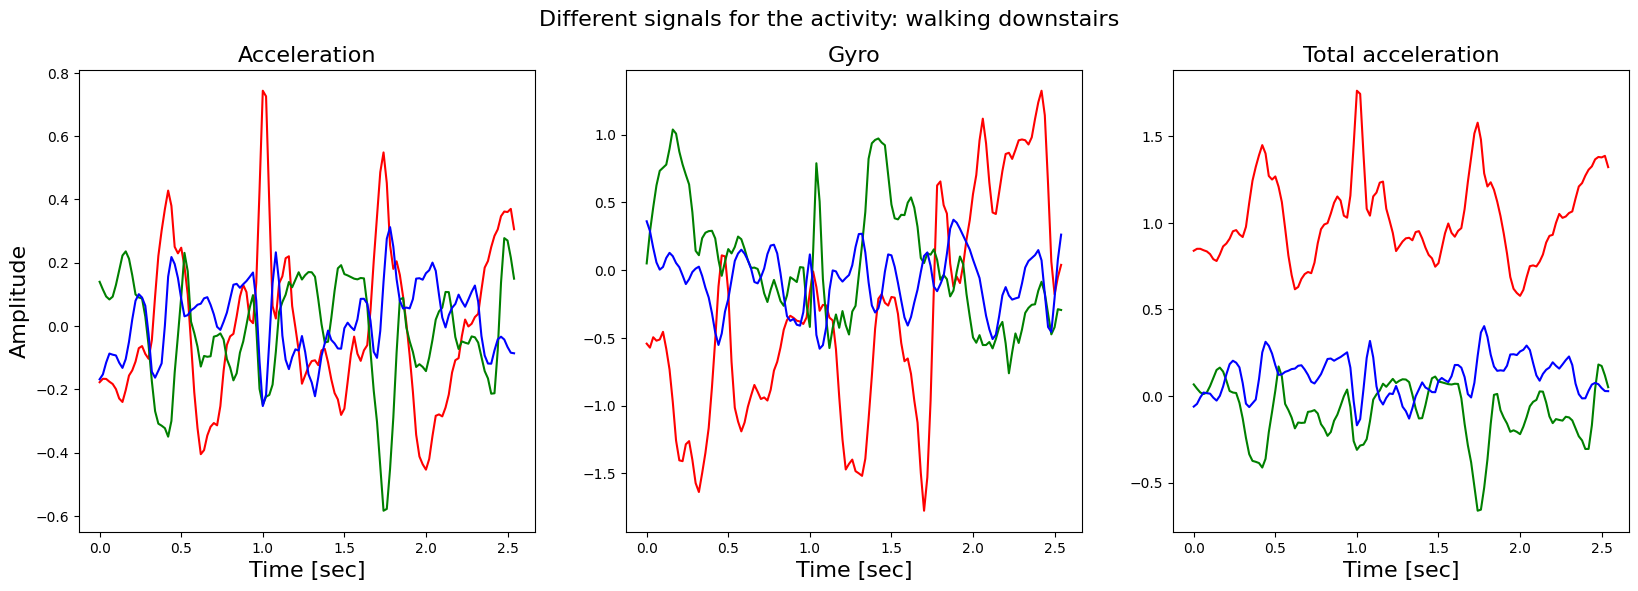

In [13]:
signal_no = 260
signals = train_signals[signal_no, :, :]
label = train_labels[signal_no]
activity_name = activities_description[label]
 
f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
f.suptitle(suptitle.format(activity_name), fontsize=16)
 
for comp_no in range(0,9):
    col_no = comp_no // 3
    plot_no = comp_no % 3
    color = colors[plot_no]
    label = labels[plot_no]
    axtitle  = axtitles[col_no]
    ax = axarr[col_no]
    ax.set_title(axtitle, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    if col_no == 0:
        ax.set_ylabel(ylabel, fontsize=16)

    signal_component = signals[:, comp_no]
    x_values, y_values = get_values(signal_component, T, N, f_s)
    ax.plot(x_values, y_values, linestyle='-', color=color, label=label)

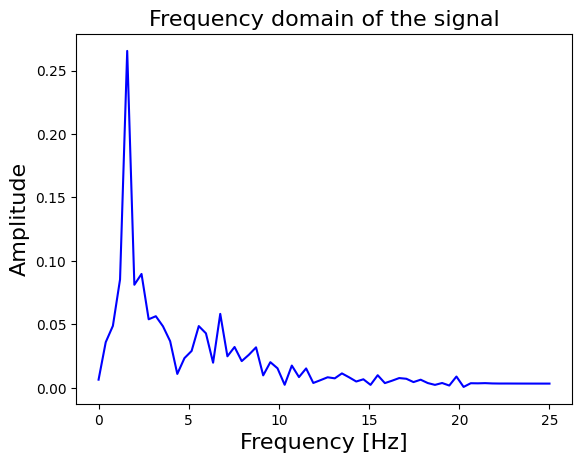

In [14]:
def get_fft_values(y_values, T, N, f_s):  
    # 
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

f_values, fft_values = get_fft_values(signals[:, 0], T, N, f_s)

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

# 2. Feature Extraction

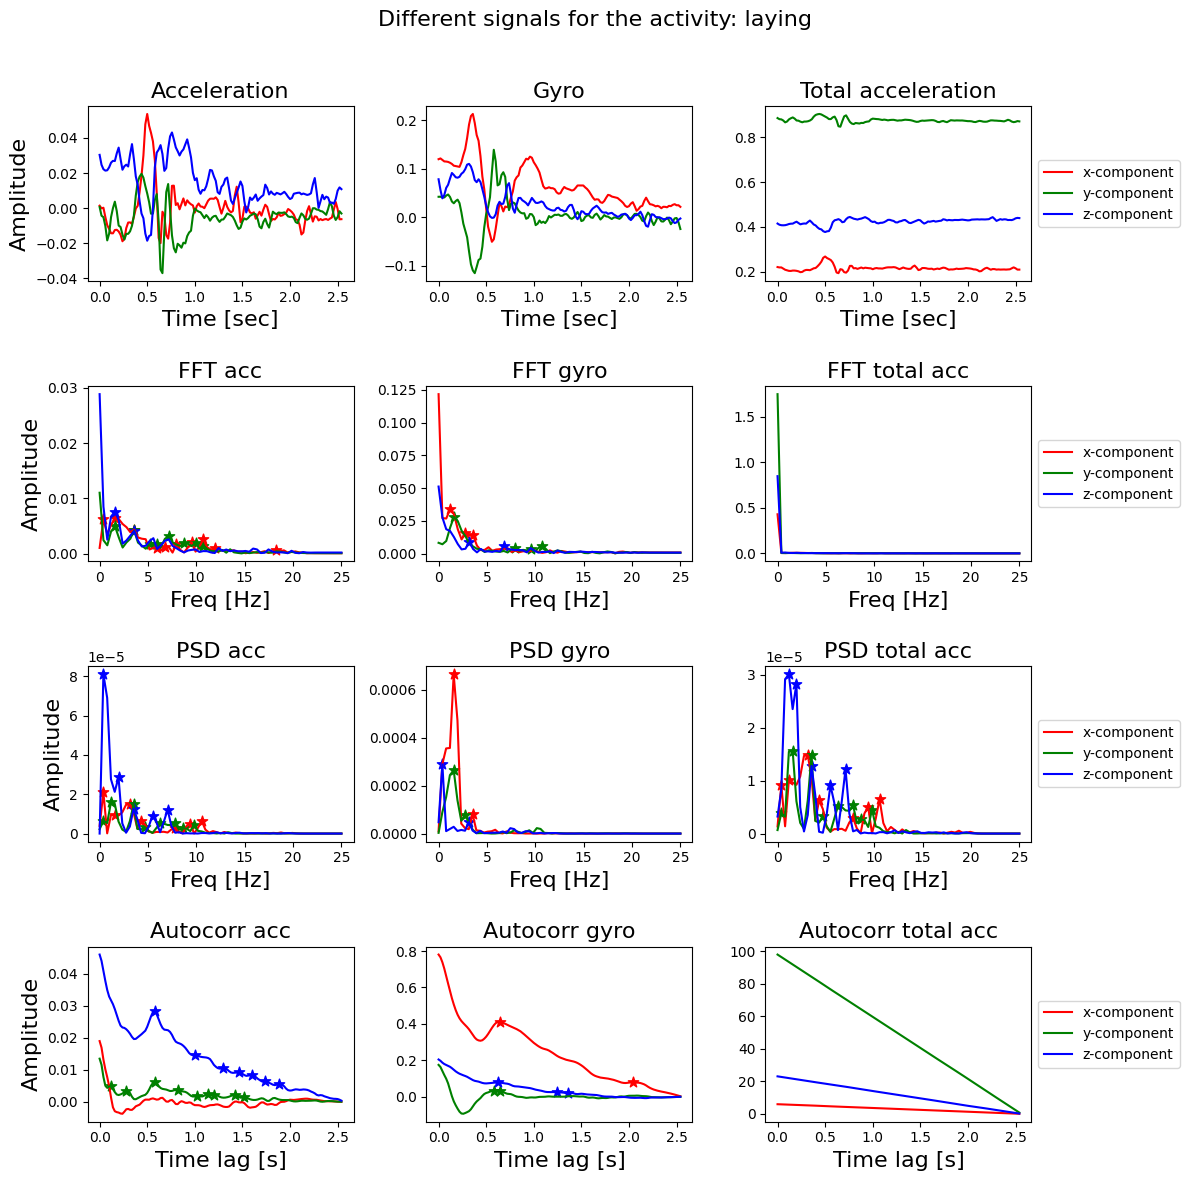

In [15]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = np.array([sample_rate * kk for kk in range(0,len(y_values))])
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
 
####
 
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]
 
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]
 
N = 128
f_s = 50
t_n = 2.56
T = t_n / N
 
signal_no = 10
signals = train_signals[signal_no, :, :]
label = train_labels[signal_no]
activity_name = activities_description[label]
 
f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle.format(activity_name), fontsize=16)
 
for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(
                x_values[indices_peaks], 
                y_values[indices_peaks], 
                c=color, 
                marker='*', 
                s=60
            )
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

In [16]:
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in tqdm(range(0, len(dataset)), leave=False):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

denominator = 10
X_train, Y_train = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
X_test, Y_test = extract_features_labels(test_signals, test_labels, T, N, f_s, denominator)

  0%|          | 0/7352 [00:00<?, ?it/s]

  0%|          | 0/2947 [00:00<?, ?it/s]

In [17]:
X_train.shape, X_test.shape

((7352, 270), (2947, 270))

# 3. ML

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
## Baseline - combine all signals in one long row

In [19]:
train_signals.shape

(7352, 128, 9)

In [20]:
X_train_flattened = train_signals.reshape(train_signals.shape[0], -1)
X_test_flattened = test_signals.reshape(test_signals.shape[0], -1)

In [21]:
X_train_flattened.shape, X_test_flattened.shape

((7352, 1152), (2947, 1152))

In [22]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_flattened, Y_train)
print("Accuracy on training set is : {:.2f}%".format(
    100*clf.score(X_train_flattened, Y_train))
     )
print("Accuracy on test set is : {:.2f}%".format(
    100*clf.score(X_test_flattened, Y_test))
     )
Y_test_pred = clf.predict(X_test_flattened)
print(classification_report(Y_test, Y_test_pred, target_names=activities_labels))

Accuracy on training set is : 100.00%
Accuracy on test set is : 85.37%
                    precision    recall  f1-score   support

           walking       0.81      0.88      0.84       496
  walking upstairs       0.85      0.80      0.83       471
walking downstairs       0.85      0.88      0.86       420
           sitting       0.76      0.79      0.78       491
          standing       0.84      0.76      0.80       532
            laying       1.00      1.00      1.00       537

          accuracy                           0.85      2947
         macro avg       0.85      0.85      0.85      2947
      weighted avg       0.85      0.85      0.85      2947



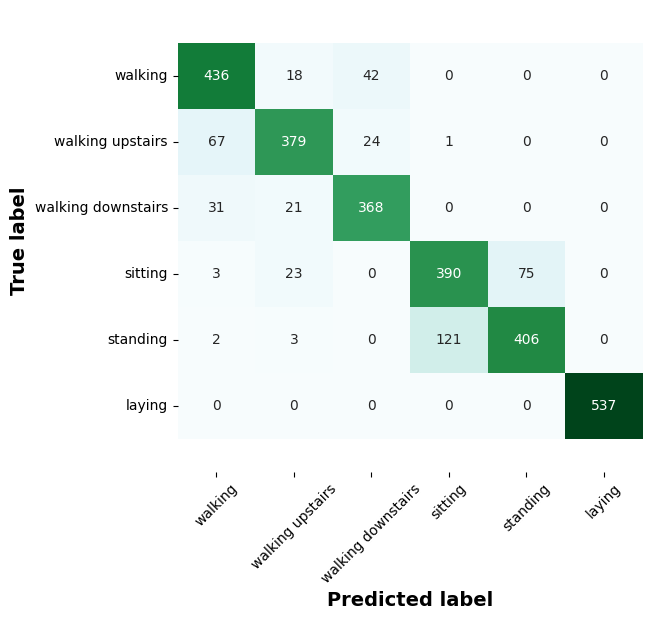

In [23]:
plot_confusion(Y_test, Y_test_pred, activities_description.values())

In [24]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {:.2f}%".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {:.2f}%".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred, target_names=activities_labels))

Accuracy on training set is : 1.00%
Accuracy on test set is : 0.88%
                    precision    recall  f1-score   support

           walking       0.93      0.98      0.95       496
  walking upstairs       0.93      0.95      0.94       471
walking downstairs       0.96      0.87      0.91       420
           sitting       0.78      0.74      0.76       491
          standing       0.78      0.92      0.84       532
            laying       0.92      0.80      0.86       537

          accuracy                           0.88      2947
         macro avg       0.88      0.88      0.88      2947
      weighted avg       0.88      0.88      0.88      2947



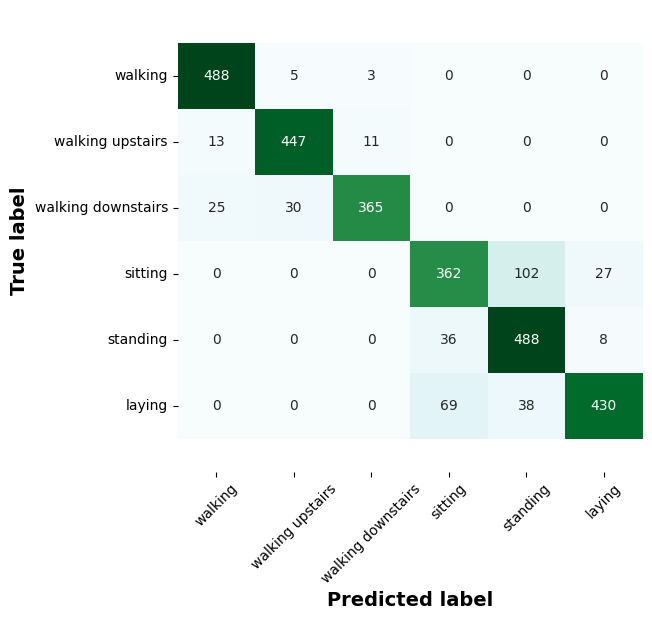

In [25]:
plot_confusion(Y_test, Y_test_pred, activities_description.values())